# Implementation of Vector Quantized Variational AutoEncoder (VQ-VAE)


## Step 1. Import Library

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.utils as vutils
import time
import seaborn as sns
from matplotlib.colors import to_rgb

%matplotlib inline

## Step 2. Set Hyperparameters

In [2]:
batch_size = 128
embedding_dim = 16
num_embeddings = 128

epochs = 100
print_freq = 100

lr = 1e-3

## Step 3. Load Dataset

In [3]:
transform=transforms.Compose([
    transforms.ToTensor(),
])

dataset1 = datasets.MNIST('~/datasets', train=True, download=True,
                       transform=transform)
dataset2 = datasets.MNIST('~/datasets', train=False,
                       transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size, shuffle=False)

# compute the variance of the whole training set to normalise the Mean Squared Error
train_images = []
for images, labels in train_loader:
#     print(images.shape)
#     print(labels.shape)
    train_images.append(images)
train_images = torch.cat(train_images, dim=0) #按维数0（行）拼接
train_data_variance = torch.var(train_images)

In [4]:
# for i, (images, labels) in enumerate(train_loader):
#         images = images - 0.5 # normalize to [-0.5, 0.5]
#         images = images.cuda()
#         print(images.shape)
#         print(labels.shape)

In [5]:
# imgs,_ = next(iter(train_loader))
# imgs = (imgs * 255).to(torch.long)
# imgs = imgs.cuda()
# print(imgs.shape)
# sns.set()
# plot_args = {"color": to_rgb("C0")+(0.5,), "edgecolor": "C0", "linewidth": 0.5, "width": 1.0}
# plt.hist(imgs.view(-1).cpu().numpy(), bins=256, density=True, **plot_args)
# plt.yscale("log")
# plt.xticks([0,64,128,192,256])
# plt.show()
# plt.close()

In [6]:
# n_samples = 400
# images = train_images[300:700]
# real_images = images * 255
# real_images = real_images.reshape(20, 20, 28, 28)
# print(real_images.shape)

In [7]:
#fig = plt.figure(figsize=(20, 20))
#gs = fig.add_gridspec(10, 10)

#for n_row in range(20):
    #for n_col in range(20):
        #image = real_images[n_row, n_col]
        #print(image.shape)
        #if image.shape == torch.Size([28,28]):
            #image = torch.unsqueeze(image, dim=0)
            #image = torch.unsqueeze(image, dim=0)
        #image = image.cuda()
        #output = network(image)
        #label = output.data.max(dim = 1, keepdim=True)[1].item()
        #for z in range(10):
               # if label == z:
                    #plt.imsave('./real_images/'+str(z)+'/'+str(n_row)+str(n_col) + '.png', image.cpu().squeeze(0).squeeze(0), cmap="gray")
                #axes[i][j].imshow(image.cpu().squeeze(0).squeeze(0), cmap='gray')
        #f_ax = fig.add_subplot(gs[n_row, n_col])
        #f_ax.imshow(real_images[n_row, n_col], cmap="gray")
        #f_ax.axis("off")
#plt.tight_layout(pad=0.)
#plt.savefig('real_image.jpg')

## Step 4. Define Model: Vector Quantized Variational AutoEncoder (VQ-VAE)

### A. Embedding Space (Codebook)

In [8]:
class VectorQuantizer(nn.Module):
    """
    VQ-VAE layer: Input any tensor to be quantized. 
    Args:
        embedding_dim (int): the dimensionality of the tensors in the
          quantized space. Inputs to the modules must be in this format as well.
        num_embeddings (int): the number of vectors in the quantized space.
        commitment_cost (float): scalar which controls the weighting of the loss terms (see
          equation 4 in the paper - this variable is Beta).
    """
    def __init__(self, embedding_dim, num_embeddings, commitment_cost):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        
        # initialize embeddings
        self.embeddings = nn.Embedding(self.num_embeddings, self.embedding_dim)
        
    def forward(self, x):
        # [B, C, H, W] -> [B, H, W, C]
        x = x.permute(0, 2, 3, 1).contiguous()
        # [B, H, W, C] -> [BHW, C]
        flat_x = x.reshape(-1, self.embedding_dim)
        
        encoding_indices = self.get_code_indices(flat_x)
        quantized = self.quantize(encoding_indices)
        quantized = quantized.view_as(x) # [B, H, W, C]
        
        if not self.training:
            quantized = quantized.permute(0, 3, 1, 2).contiguous()
            return quantized
        
        # embedding loss: move the embeddings towards the encoder's output
        embedding_loss = F.mse_loss(quantized, x.detach())
        # commitment loss
        e_latent_loss = F.mse_loss(x, quantized.detach())
        commitment_loss = embedding_loss + self.commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = x + (quantized - x).detach()
        
        quantized = quantized.permute(0, 3, 1, 2).contiguous()
        return encoding_indices, quantized, embedding_loss, commitment_loss
    
    def get_code_indices(self, flat_x):
        # compute L2 distance
        distances = (
            torch.sum(flat_x ** 2, dim=1, keepdim=True) +
            torch.sum(self.embeddings.weight ** 2, dim=1) -
            2. * torch.matmul(flat_x, self.embeddings.weight.t())
        ) # [N, M]
        encoding_indices = torch.argmin(distances, dim=1) # [N,]
        return encoding_indices
    
    def quantize(self, encoding_indices):
        """Returns embedding tensor for a batch of indices."""
        return self.embeddings(encoding_indices)      

### B. Encoder

In [9]:
class Encoder(nn.Module):
    """Encoder of VQ-VAE"""
    
    def __init__(self, in_dim=3, latent_dim=16):
        super().__init__()
        self.in_dim = in_dim
        self.latent_dim = latent_dim
        
        self.convs = nn.Sequential(
            nn.Conv2d(in_dim, 32, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, latent_dim, 1),
        )
        
    def forward(self, x):
        return self.convs(x)
    

In [10]:
# encoder = Encoder(1, embedding_dim)
# embeddings = nn.Embedding(num_embeddings, embedding_dim)
# print(embeddings.weight.shape)

In [11]:
# for i, (images, labels) in enumerate(train_loader):
#         images = images - 0.5 # normalize to [-0.5, 0.5]
#         print(images.shape)
#         #images = images.cuda()
#         encoder_output = encoder(images)
#         print(encoder_output.shape)
#         x = encoder_output.permute(0, 2, 3, 1).contiguous() # change the position of dimensions
#         #print(x.shape)
#         # [B, H, W, C] -> [BHW, C]
#         flat_x = x.reshape(-1, embedding_dim)
#         print(flat_x.shape)
#         distances = (
#             torch.sum(flat_x.cpu() ** 2, dim=1, keepdim=True) +
#             torch.sum(embeddings.weight.cpu() ** 2, dim=1) - 
#             2. * torch.matmul(flat_x.cpu(), embeddings.weight.cpu().t())
#         )
#         #print(distances.shape)
#         encoding_indices = torch.argmin(distances, dim=1)
#         #print(encoding_indices.shape)
#         quantized = embeddings(encoding_indices)
#         #print(quantized.shape)
#         quantized = quantized.view_as(x) 
#         #print(quantized.shape)
#         quantized = x + (quantized - x).detach()
#         #print(quantized.shape)
#         quantized = quantized.permute(0, 3, 1, 2).contiguous()
#         print(quantized.shape)
        
       
    

### C. Decoder

In [12]:
class Decoder(nn.Module):
    """Decoder of VQ-VAE"""
    
    def __init__(self, out_dim=1, latent_dim=16):
        super().__init__()
        self.out_dim = out_dim
        self.latent_dim = latent_dim
        
        self.convs = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, out_dim, 3, padding=1),
        )
        
    def forward(self, x):
        return self.convs(x)
        

In [13]:
# decoder = Decoder(1, embedding_dim)
# encoder = Encoder(1, embedding_dim)
# embeddings = nn.Embedding(num_embeddings, embedding_dim)
# print(embeddings.weight.shape)

In [14]:
# for i, (images, labels) in enumerate(train_loader):
#         images = images - 0.5 # normalize to [-0.5, 0.5]
#         #print(images.shape)
#         #images = images.cuda()
#         encoder_output = encoder(images)
#         #print(encoder_output.shape)
#         x = encoder_output.permute(0, 2, 3, 1).contiguous() # change the position of dimensions
#         #print(x.shape)
#         # [B, H, W, C] -> [BHW, C]
#         flat_x = x.reshape(-1, embedding_dim)
#         #print(flat_x.shape)
#         distances = (
#             torch.sum(flat_x.cpu() ** 2, dim=1, keepdim=True) +
#             torch.sum(embeddings.weight.cpu() ** 2, dim=1) - 
#             2. * torch.matmul(flat_x.cpu(), embeddings.weight.cpu().t())
#         )
#         #print(distances.shape)
#         encoding_indices = torch.argmin(distances, dim=1)
#         #print(encoding_indices.shape)
#         quantized = embeddings(encoding_indices)
#         #print(quantized.shape)
#         quantized = quantized.view_as(x) 
#         #print(quantized.shape)
#         quantized = x + (quantized - x).detach()
#         #print(quantized.shape)
#         quantized = quantized.permute(0, 3, 1, 2).contiguous()
#         #print(quantized.shape)
#         x_recon = decoder(quantized)
#         print(x_recon.shape)
       
    

### D. VQ-VAE

In [15]:
class VQVAE(nn.Module):
    """VQ-VAE"""
    
    def __init__(self, in_dim, embedding_dim, num_embeddings, data_variance, 
                 commitment_cost=0.25):
        super().__init__()
        self.in_dim = in_dim
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.data_variance = data_variance
        
        self.encoder = Encoder(in_dim, embedding_dim)
        self.vq_layer = VectorQuantizer(embedding_dim, num_embeddings, commitment_cost)
        self.decoder = Decoder(in_dim, embedding_dim)
        
    def forward(self, x):
        z = self.encoder(x)
        if not self.training:
            e = self.vq_layer(z)
            x_recon = self.decoder(e)
            return e, x_recon
        
        index, e, embedding_loss, commitment_loss = self.vq_layer(z)
        x_recon = self.decoder(e)
        
        recon_loss = F.mse_loss(x_recon, x) / self.data_variance
        
        return index, e, embedding_loss, commitment_loss, x_recon, recon_loss 

In [16]:
model = VQVAE(1, embedding_dim, num_embeddings, train_data_variance)
model = model.cuda()

## Step 5. Define Optimizer

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [18]:
# from torch.utils.tensorboard import SummaryWriter

# writer = SummaryWriter("./runs/")


## Step 6. Train

In [19]:
# train VQ-VAE

for epoch in range(epochs):
    print("Start training epoch {}".format(epoch,))
    for i, (images, labels) in enumerate(train_loader):
        images = images - 0.5 # normalize to [-0.5, 0.5]
        images = images.cuda()
        
        optimizer.zero_grad()
        
        index, e, embedding_loss, commitment_loss, x_recon, recon_loss = model(images)
        loss = embedding_loss + commitment_loss + recon_loss
        
        loss.backward()
        optimizer.step()
        
        if (i + 1) % print_freq == 0 or (i + 1) == len(train_loader):
            print("\t [{}/{}]: loss {}".format(i, len(train_loader), loss.item()))

Start training epoch 0
	 [99/469]: loss 1.3042981624603271
	 [199/469]: loss 1.337390661239624
	 [299/469]: loss 1.0336666107177734
	 [399/469]: loss 0.9680349230766296
	 [468/469]: loss 0.845215380191803
Start training epoch 1
	 [99/469]: loss 0.7511025667190552
	 [199/469]: loss 0.6644664406776428
	 [299/469]: loss 0.5738097429275513
	 [399/469]: loss 0.539949357509613
	 [468/469]: loss 0.5557311773300171
Start training epoch 2
	 [99/469]: loss 0.48495352268218994
	 [199/469]: loss 0.5062964558601379
	 [299/469]: loss 0.4659876525402069
	 [399/469]: loss 0.4782204031944275
	 [468/469]: loss 0.46243926882743835
Start training epoch 3
	 [99/469]: loss 0.42604801058769226
	 [199/469]: loss 0.43147051334381104
	 [299/469]: loss 0.43966105580329895
	 [399/469]: loss 0.4289468228816986
	 [468/469]: loss 0.4434727132320404
Start training epoch 4
	 [99/469]: loss 0.4266705811023712
	 [199/469]: loss 0.42234092950820923
	 [299/469]: loss 0.40910565853118896
	 [399/469]: loss 0.406789362430572

	 [99/469]: loss 0.2626287341117859
	 [199/469]: loss 0.2704105079174042
	 [299/469]: loss 0.269570529460907
	 [399/469]: loss 0.26739585399627686
	 [468/469]: loss 0.2568187713623047
Start training epoch 40
	 [99/469]: loss 0.26397398114204407
	 [199/469]: loss 0.2615024149417877
	 [299/469]: loss 0.2747381627559662
	 [399/469]: loss 0.2612050771713257
	 [468/469]: loss 0.2531172037124634
Start training epoch 41
	 [99/469]: loss 0.26202061772346497
	 [199/469]: loss 0.2632334232330322
	 [299/469]: loss 0.25381991267204285
	 [399/469]: loss 0.2596071660518646
	 [468/469]: loss 0.25796085596084595
Start training epoch 42
	 [99/469]: loss 0.25872671604156494
	 [199/469]: loss 0.2705793082714081
	 [299/469]: loss 0.2640554904937744
	 [399/469]: loss 0.2568150460720062
	 [468/469]: loss 0.24980881810188293
Start training epoch 43
	 [99/469]: loss 0.2769950330257416
	 [199/469]: loss 0.23855116963386536
	 [299/469]: loss 0.2515290379524231
	 [399/469]: loss 0.24916642904281616
	 [468/469]: 

	 [99/469]: loss 0.2389453798532486
	 [199/469]: loss 0.23966924846172333
	 [299/469]: loss 0.2391095757484436
	 [399/469]: loss 0.23005476593971252
	 [468/469]: loss 0.23990023136138916
Start training epoch 79
	 [99/469]: loss 0.23635685443878174
	 [199/469]: loss 0.238132044672966
	 [299/469]: loss 0.23858089745044708
	 [399/469]: loss 0.22737489640712738
	 [468/469]: loss 0.2473732829093933
Start training epoch 80
	 [99/469]: loss 0.23911719024181366
	 [199/469]: loss 0.23955492675304413
	 [299/469]: loss 0.23175588250160217
	 [399/469]: loss 0.24039092659950256
	 [468/469]: loss 0.24133069813251495
Start training epoch 81
	 [99/469]: loss 0.24506834149360657
	 [199/469]: loss 0.24353137612342834
	 [299/469]: loss 0.2494249790906906
	 [399/469]: loss 0.2407507598400116
	 [468/469]: loss 0.247402161359787
Start training epoch 82
	 [99/469]: loss 0.2355741709470749
	 [199/469]: loss 0.24535004794597626
	 [299/469]: loss 0.24913297593593597
	 [399/469]: loss 0.22419975697994232
	 [468/

In [20]:
# plt.rcParams['figure.figsize'] = (15, 10)
# plt.plot(recon_loss_list)

In [21]:
# plt.plot(embedding_loss_list)

In [22]:
# plt.plot(commitment_loss_list)

In [23]:
# plt.plot(loss_list)

In [24]:
torch.save(model, './model_VQVAE.pth')
torch.save(optimizer, './optimizer_VQVAE.pth')

In [25]:
model = torch.load('./model_VQVAE.pth')
optimizer = torch.load('./optimizer_VQVAE.pth')

## Step 9. Generate New Images

In [26]:
# get encode_indices of training images
train_indices = []
label_indices = []
for images, labels in train_loader:
    images = images - 0.5 # normalize to [-0.5, 0.5]
    images = images.cuda()
    with torch.inference_mode():
        z = model.encoder(images) # [B, C, H, W]
        b, c, h, w = z.size()
        # [B, C, H, W] -> [B, H, W, C]
        z = z.permute(0, 2, 3, 1).contiguous()
        # [B, H, W, C] -> [BHW, C]
        flat_z = z.reshape(-1, c)
        encoding_indices = model.vq_layer.get_code_indices(flat_z) # [BHW,]
        encoding_indices = encoding_indices.reshape(b, h, w)
#         print(encoding_indices.cpu().shape)
        train_indices.append(encoding_indices.cpu())
        label_indices.append(labels.cpu())
# print(len(label_indices))
# print(len(train_indices))

In [27]:
# get encode_indices of training images
test_indices = []
test_images = []
quantized_vectors = []
for images, labels in test_loader:
    images = images - 0.5 # normalize to [-0.5, 0.5]
    images = images.cuda()
    test_images.append(images)
    with torch.inference_mode():
        z = model.encoder(images) # [B, C, H, W]
        b, c, h, w = z.size()
        # [B, C, H, W] -> [B, H, W, C]
        z = z.permute(0, 2, 3, 1).contiguous()
        # [B, H, W, C] -> [BHW, C]
        flat_z = z.reshape(-1, c)
        encoding_indices = model.vq_layer.get_code_indices(flat_z) # [BHW,]
        encoding_indices = encoding_indices.reshape(b, h, w)
        #print(encoding_indices.shape)
        test_indices.append(encoding_indices.cpu())
        quantized = model.vq_layer.quantize(encoding_indices)
        quantized = quantized.permute(0, 3, 1, 2).contiguous()
        quantized_vectors.append(quantized)

# Reconstructing the image from the test set: simply let the test dataset pass through the whole VQVAE to get the reconstructed image for comparison with the original

In [28]:
recon_images = []
for images, labels in test_loader:
    images = images - 0.5 # normalize to [-0.5, 0.5]
    images = images.cuda()
    with torch.inference_mode():
        z = model.encoder(images)
        index, e, embedding_loss, commitment_loss = model.vq_layer(z)
        x_recon = model.decoder(e)
        recon_images.append(x_recon)

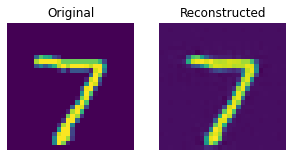

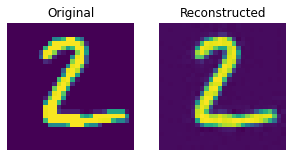

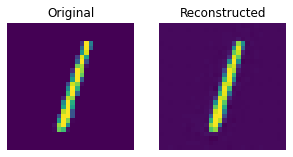

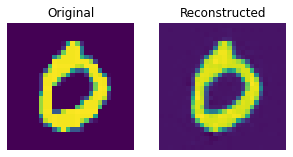

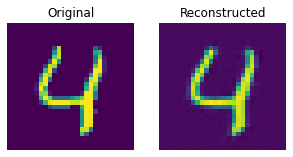

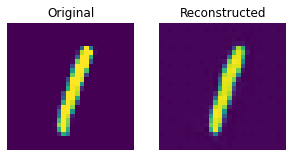

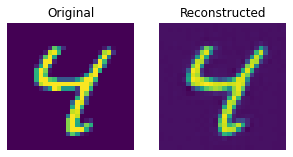

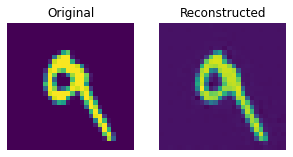

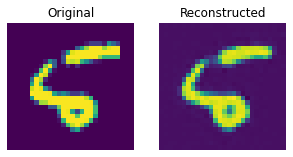

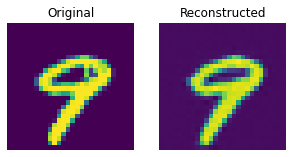

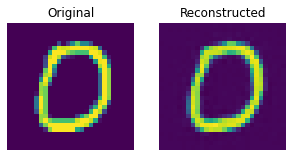

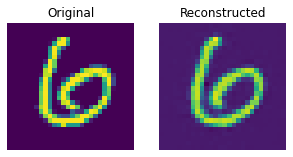

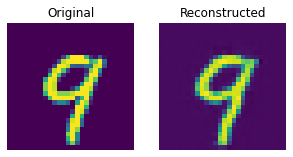

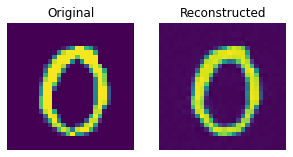

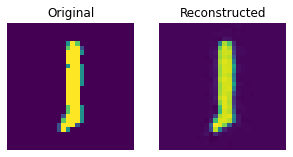

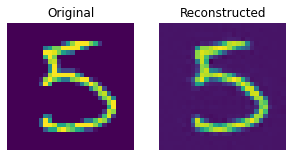

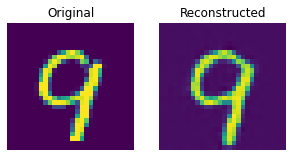

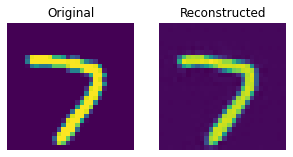

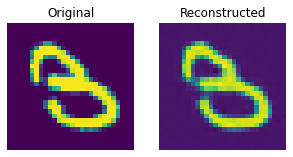

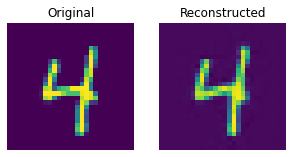

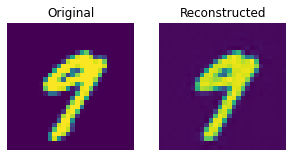

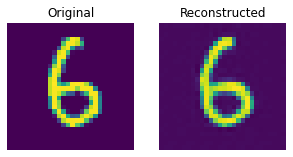

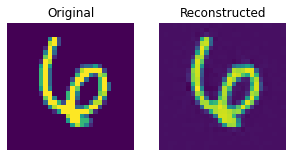

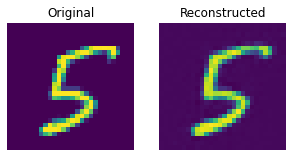

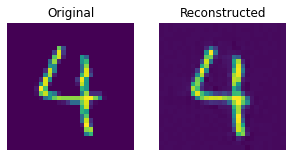

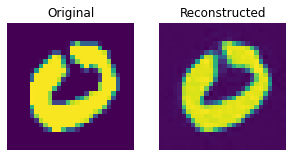

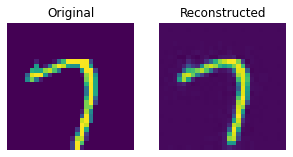

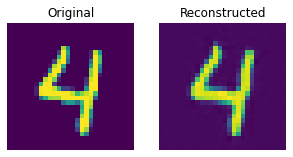

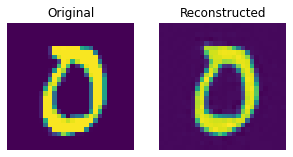

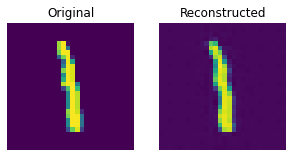

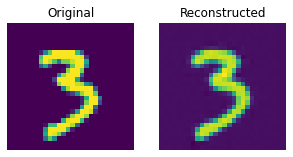

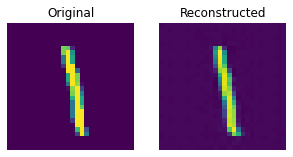

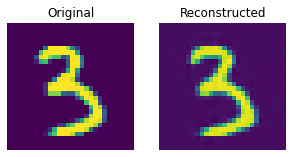

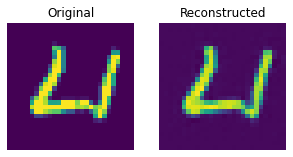

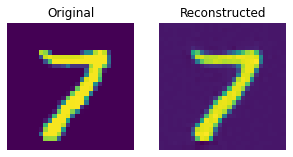

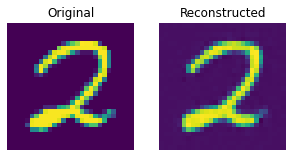

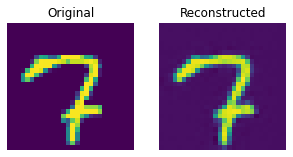

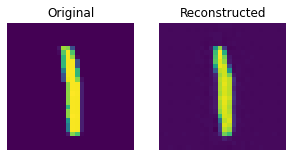

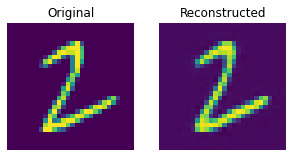

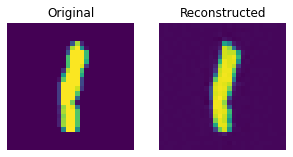

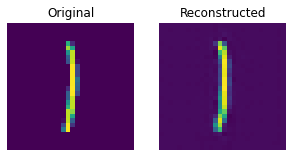

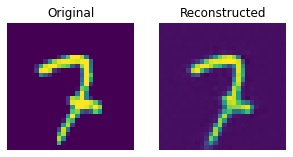

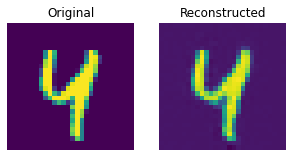

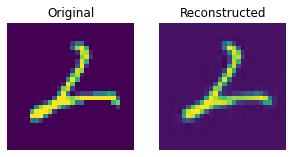

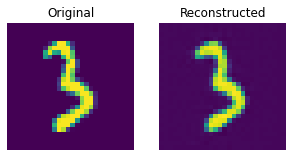

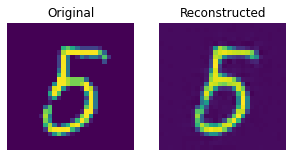

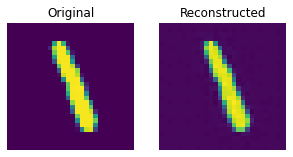

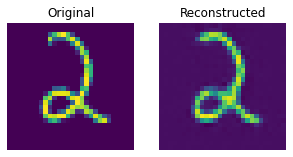

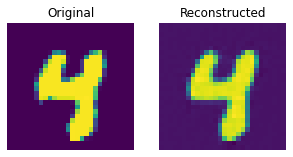

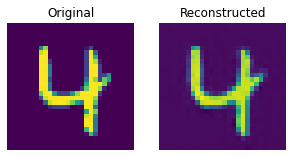

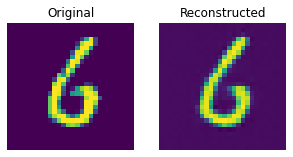

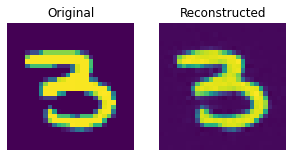

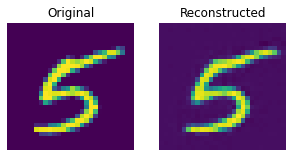

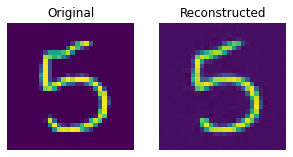

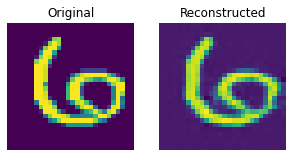

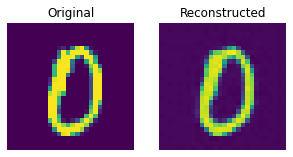

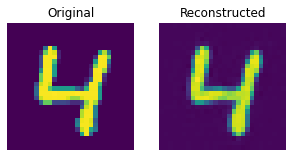

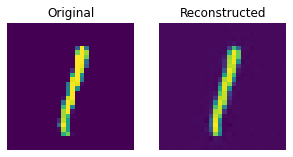

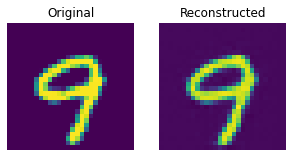

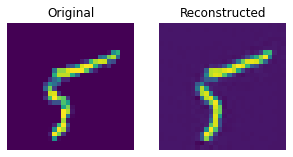

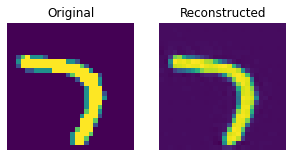

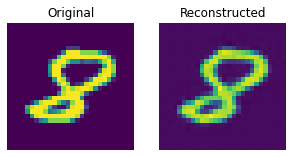

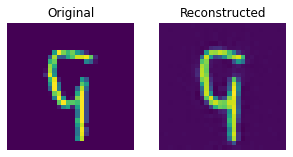

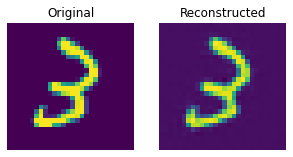

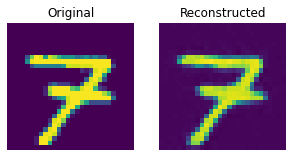

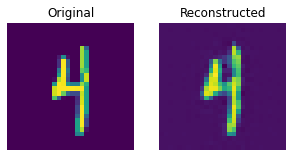

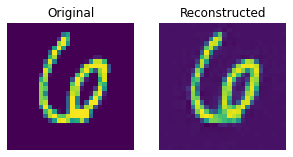

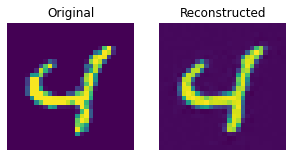

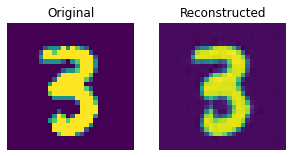

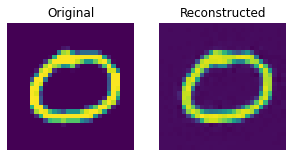

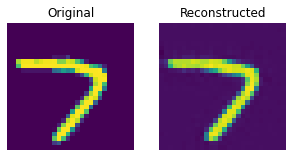

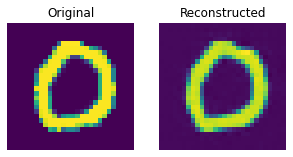

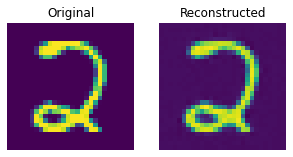

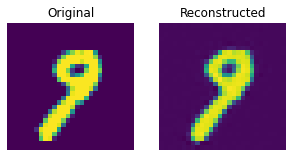

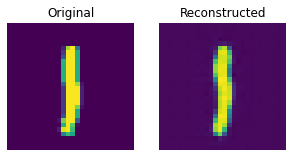

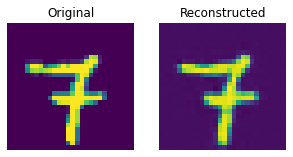

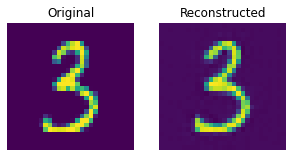

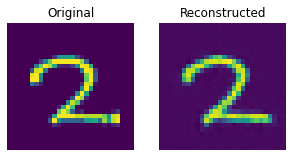

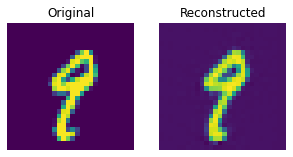

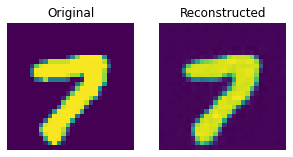

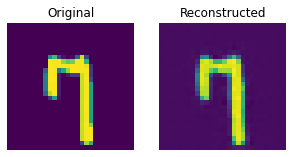

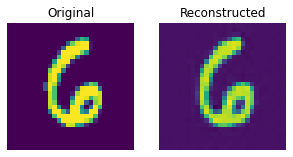

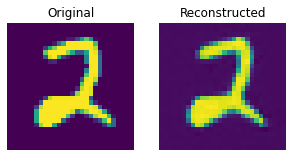

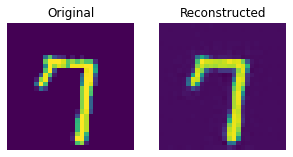

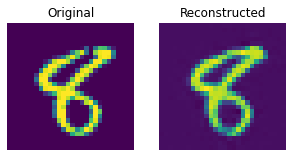

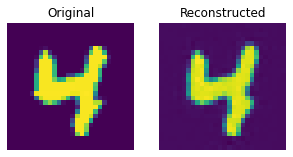

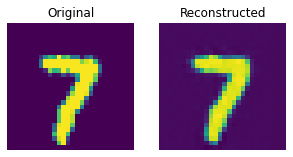

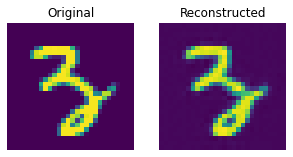

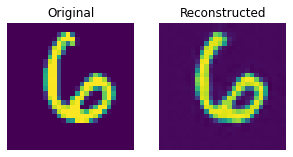

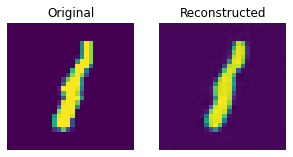

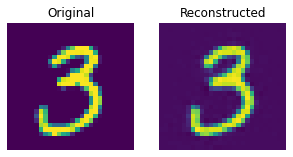

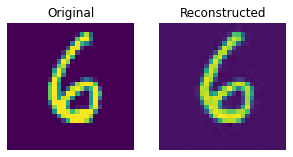

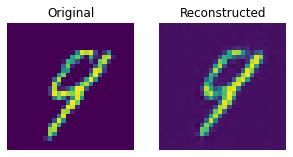

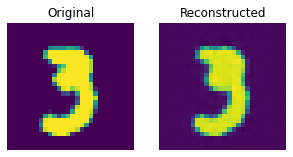

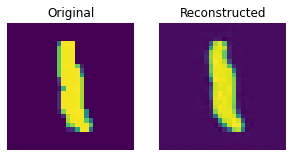

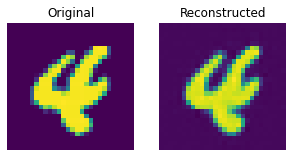

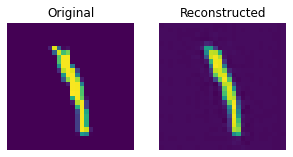

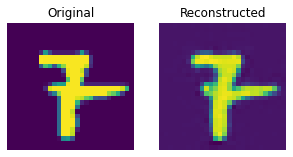

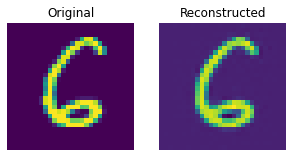

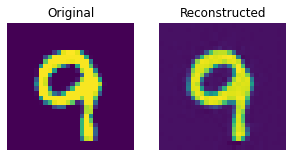

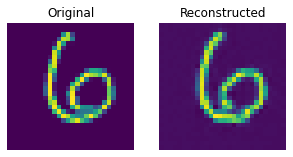

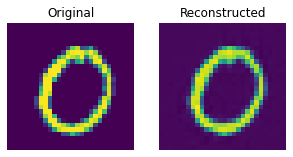

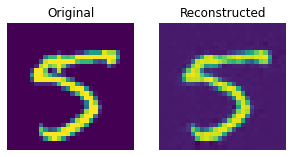

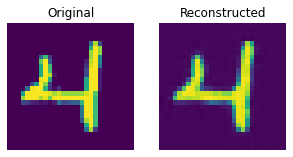

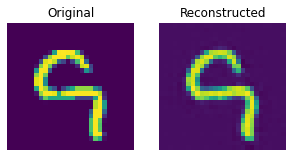

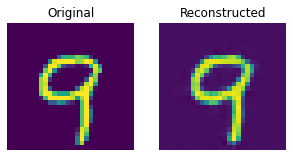

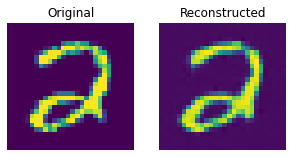

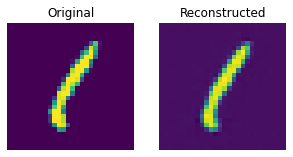

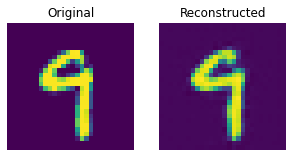

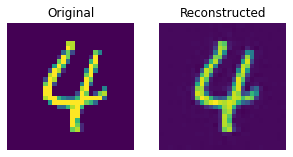

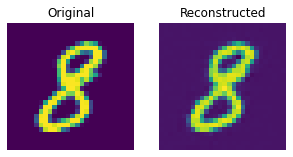

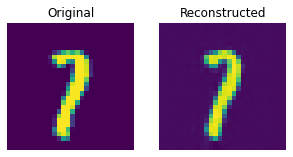

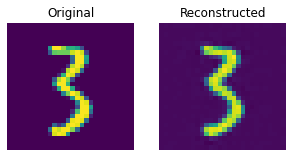

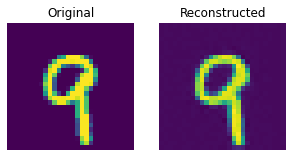

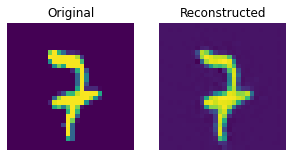

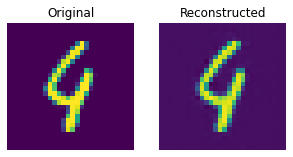

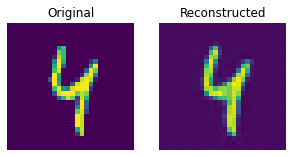

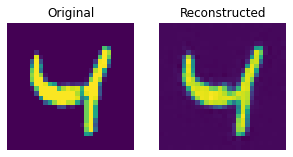

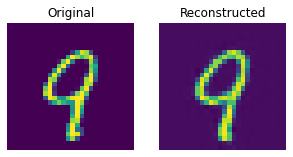

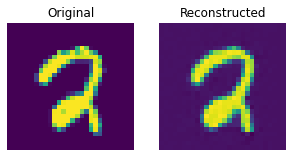

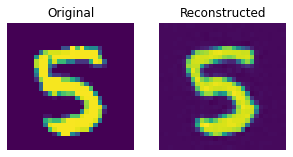

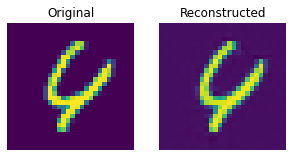

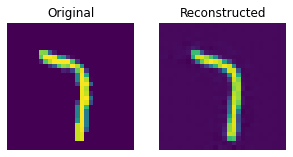

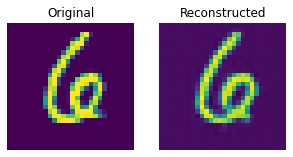

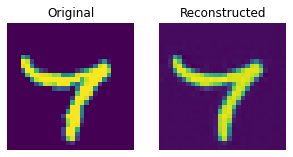

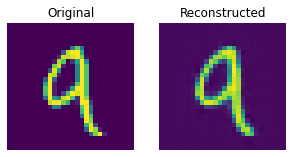

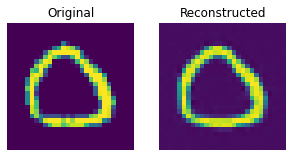

In [29]:
plt.rcParams['figure.figsize'] = (5, 5)
test_image = test_images[0]
recon_image = recon_images[0]
for i in range(127):
    
    image = test_image[i]
    #print(image.shape)
    image_r = recon_image[i]


    plt.subplot(1, 2, 1)
    plt.imshow(image.cpu().squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(image_r.cpu().squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()

In [30]:
# easy_list=[3, 2, 1, 18, 4, 8, 11, 0, 61, 9] # 0 1 2 3 4 5 6 7 8 9 的位置

In [32]:
# test_index = test_indices[0]
# print(test_index.shape)
# test_image = test_images[0]
# print(test_image.shape)
# quantized_vector_1 = quantized_vectors[0]
# print(quantized_vector_1.shape)

# for j in range(10):
#     i = easy_list[j]
#     index = test_index[i]
#     #print(index.shape)
#     image = test_image[i]
#     #print(image.shape)
#     #     quantized_vector = quantized_vector[i]


#     plt.subplot(1, 2, 1)
#     plt.imshow(image.cpu().squeeze() + 0.5)
#     plt.title("Original")
#     plt.axis("off")

#     plt.subplot(1, 2, 2)
#     plt.imshow(index.cpu())
#     plt.title("Code")
#     plt.axis("off")

#     plt.savefig('./latent_dim_8/' + str(j) + '_1.jpg')


In [33]:

# for j in range(10):
#     i = easy_list[j]
#     quantized_vector_2 = quantized_vector_1[i]
#     plt.rcParams['figure.figsize'] = (15, 5)
#     #print(quantized_vector_2)
#     for k in range(8):
#         quantized_vector_3 = quantized_vector_2[k]
#         plt.subplot(1, 8, k+1)
#         plt.imshow(quantized_vector_3.cpu())
#         plt.axis("off")
#         plt.savefig('./latent_dim_8/' + str(j) + '_2.jpg')
    
# #     plt.show()
        
        
    

# Gated PixelCNN

In [34]:
# # train PixelCNN to generate new images

# class MaskedConv2d(nn.Conv2d):
#     """
#     Implements a conv2d with mask applied on its weights.
    
#     Args:
#         mask (torch.Tensor): the mask tensor.
#         in_channels (int) – Number of channels in the input image.
#         out_channels (int) – Number of channels produced by the convolution.
#         kernel_size (int or tuple) – Size of the convolving kernel
#     """
    
#     def __init__(self, mask, in_channels, out_channels, kernel_size, **kwargs):
#         super().__init__(in_channels, out_channels, kernel_size, **kwargs)
#         self.register_buffer('mask', mask[None, None])
        
#     def forward(self, x):
#         self.weight.data *= self.mask # mask weights
#         return super().forward(x)
    

# class VerticalStackConv(MaskedConv2d):

#     def __init__(self, mask_type, in_channels, out_channels, kernel_size, **kwargs):
#         # Mask out all pixels below. For efficiency, we could also reduce the kernel
#         # size in height (k//2, k), but for simplicity, we stick with masking here.
#         self.mask_type = mask_type
        
#         if isinstance(kernel_size, int):
#             kernel_size = (kernel_size, kernel_size)
#         mask = torch.zeros(kernel_size)
#         mask[:kernel_size[0]//2, :] = 1.0
#         if self.mask_type == "B":
#             mask[kernel_size[0]//2, :] = 1.0

#         super().__init__(mask, in_channels, out_channels, kernel_size, **kwargs)
        

# class HorizontalStackConv(MaskedConv2d):

#     def __init__(self, mask_type, in_channels, out_channels, kernel_size, **kwargs):
#         # Mask out all pixels on the left. Note that our kernel has a size of 1
#         # in height because we only look at the pixel in the same row.
#         self.mask_type = mask_type
        
#         if isinstance(kernel_size, int):
#             kernel_size = (1, kernel_size)
#         assert kernel_size[0] == 1
#         if "padding" in kwargs:
#             if isinstance(kwargs["padding"], int):
#                 kwargs["padding"] = (0, kwargs["padding"])
        
#         mask = torch.zeros(kernel_size)
#         mask[:, :kernel_size[1]//2] = 1.0
#         if self.mask_type == "B":
#             mask[:, kernel_size[1]//2] = 1.0

#         super().__init__(mask, in_channels, out_channels, kernel_size, **kwargs)
        
# class GatedMaskedConv(nn.Module):

#     def __init__(self, in_channels, kernel_size=3, dilation=1):
#         """
#         Gated Convolution block implemented the computation graph shown above.
#         """
#         super().__init__()
        
#         padding = dilation * (kernel_size - 1) // 2
#         self.conv_vert = VerticalStackConv("B", in_channels, 2*in_channels, kernel_size, padding=padding,
#                                           dilation=dilation)
#         self.conv_horiz = HorizontalStackConv("B", in_channels, 2*in_channels, kernel_size, padding=padding,
#                                              dilation=dilation)
#         self.conv_vert_to_horiz = nn.Conv2d(2*in_channels, 2*in_channels, kernel_size=1)
#         self.conv_horiz_1x1 = nn.Conv2d(in_channels, in_channels, kernel_size=1)

#     def forward(self, v_stack, h_stack):
#         # Vertical stack (left)
#         v_stack_feat = self.conv_vert(v_stack)
#         v_val, v_gate = v_stack_feat.chunk(2, dim=1)
#         v_stack_out = torch.tanh(v_val) * torch.sigmoid(v_gate)

#         # Horizontal stack (right)
#         h_stack_feat = self.conv_horiz(h_stack)
#         h_stack_feat = h_stack_feat + self.conv_vert_to_horiz(v_stack_feat)
#         h_val, h_gate = h_stack_feat.chunk(2, dim=1)
#         h_stack_feat = torch.tanh(h_val) * torch.sigmoid(h_gate)
#         h_stack_out = self.conv_horiz_1x1(h_stack_feat)
#         h_stack_out = h_stack_out + h_stack

#         return v_stack_out, h_stack_out
    
    
# class GatedPixelCNN(nn.Module):
    
#     def __init__(self, in_channels, channels, out_channels):
#         super().__init__()
        
#         # Initial first conv with mask_type A
#         self.conv_vstack = VerticalStackConv("A", in_channels, channels, 3, padding=1)
#         self.conv_hstack = HorizontalStackConv("A", in_channels, channels, 3, padding=1)
#         # Convolution block of PixelCNN. use dilation instead of 
#         # downscaling used in the encoder-decoder architecture in PixelCNN++
#         self.conv_layers = nn.ModuleList([
#             GatedMaskedConv(channels),
#             GatedMaskedConv(channels, dilation=2),
#             GatedMaskedConv(channels)
#         ])
        
#         # Output classification convolution (1x1)
#         self.conv_out = nn.Conv2d(channels, out_channels, kernel_size=1)
        
#     def forward(self, x):
#         # first convolutions
#         v_stack = self.conv_vstack(x)
#         h_stack = self.conv_hstack(x)
#         # Gated Convolutions
#         for layer in self.conv_layers:
#             v_stack, h_stack = layer(v_stack, h_stack)
#         # 1x1 classification convolution
#         # Apply ELU before 1x1 convolution for non-linearity on residual connection
#         out = self.conv_out(F.elu(h_stack))
#         return out


In [35]:
# epochs = 30

# pixelcnn = GatedPixelCNN(num_embeddings, 128, num_embeddings)
# pixelcnn = pixelcnn.cuda()

# optimizer = torch.optim.Adam(pixelcnn.parameters(), lr=1e-3)

# # train pixelcnn
# print_freq = 500
# for epoch in range(epochs):
#     print("Start training epoch {}".format(epoch,))
#     for i, (indices) in enumerate(train_indices):
#         indices = indices.cuda()
#         one_hot_indices = F.one_hot(indices, num_embeddings).float().permute(0, 3, 1, 2).contiguous()
        
#         outputs = pixelcnn(one_hot_indices)
        
#         loss = F.cross_entropy(outputs, indices)
        
#         writer.add_scalar('pixelcnn_loss_2/train', float(loss), len(train_loader)*epoch+i)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         if (i + 1) % print_freq == 0 or (i + 1) == len(train_loader):
#             print("\t [{}/{}]: loss {}".format(i, len(train_loader), loss.item())) 

In [36]:
# torch.save(pixelcnn, './model_gated_PixelCNN.pth')
# torch.save(optimizer, './optimizer_gated_PixelCNN.pth')

In [37]:
# pixelcnn = torch.load('./model_gated_PixelCNN.pth')
# optimizer = torch.load('./optimizer_gated_PixelCNN.pth')

In [38]:
# n_samples = 100
# prior_size = (7, 7) # h, w
# priors = torch.zeros((n_samples,) + prior_size, dtype=torch.long).cuda()

# # use pixelcnn to generate priors
# pixelcnn.eval()

# # Iterate over the priors because generation has to be done sequentially pixel by pixel.
# for row in range(prior_size[0]):
#     for col in range(prior_size[1]):
#         # Feed the whole array and retrieving the pixel value probabilities for the next
#         # pixel.
#         with torch.inference_mode():
#             one_hot_priors = F.one_hot(priors, num_embeddings).float().permute(0, 3, 1, 2).contiguous()
#             logits = pixelcnn(one_hot_priors)
#             probs = F.softmax(logits[:, :, row, col], dim=-1)
#             # Use the probabilities to pick pixel values and append the values to the priors.
#             priors[:, row, col] = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)



In [39]:
# with torch.inference_mode():
#     z = model.vq_layer.quantize(priors)
#     z = z.permute(0, 3, 1, 2).contiguous()
#     pred = model.decoder(z)

# generated_samples = np.array(np.clip((pred + 0.5).cpu().numpy(), 0., 1.) * 255, dtype=np.uint8)
# generated_samples = generated_samples.reshape(100, 28, 28)

# # fig = plt.figure(figsize=(10, 10), constrained_layout=True)
# # gs = fig.add_gridspec(10, 10)
# # for n_row in range(10):
# #     for n_col in range(10):
# #         f_ax = fig.add_subplot(gs[n_row, n_col])
# #         f_ax.imshow(generated_samples[n_row, n_col], cmap="gray")
# #         f_ax.axis("off")
    

In [40]:
# with torch.no_grad():
#     for n in range(100):
#         generated_image = generated_samples[n]
#         plt.imsave('./15/'+str(n) + '.jpg', generated_image, cmap="gray")

# conditional Gated PixelCNN

In [41]:
# train PixelCNN to generate new images

class MaskedConv2d(nn.Conv2d):
    """
    Implements a conv2d with mask applied on its weights.
    
    Args:
        mask (torch.Tensor): the mask tensor.
        in_channels (int) – Number of channels in the input image.
        out_channels (int) – Number of channels produced by the convolution.
        kernel_size (int or tuple) – Size of the convolving kernel
    """
    
    def __init__(self, mask, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)
        self.register_buffer('mask', mask[None, None])
        
    def forward(self, x):
        self.weight.data *= self.mask # mask weights
        return super().forward(x)
    

class VerticalStackConv(MaskedConv2d):

    def __init__(self, mask_type, in_channels, out_channels, kernel_size, **kwargs):
        # Mask out all pixels below. For efficiency, we could also reduce the kernel
        # size in height (k//2, k), but for simplicity, we stick with masking here.
        self.mask_type = mask_type
          
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        mask = torch.zeros(kernel_size)
        mask[:kernel_size[0]//2, :] = 1.0
        if self.mask_type == "B":
            mask[kernel_size[0]//2, :] = 1.0

        super().__init__(mask, in_channels, out_channels, kernel_size, **kwargs)

class HorizontalStackConv(MaskedConv2d):

    def __init__(self, mask_type, in_channels, out_channels, kernel_size, **kwargs):
        # Mask out all pixels on the left. Note that our kernel has a size of 1
        # in height because we only look at the pixel in the same row.
        self.mask_type = mask_type
        
        if isinstance(kernel_size, int):
            kernel_size = (1, kernel_size)
        assert kernel_size[0] == 1
        if "padding" in kwargs:
            if isinstance(kwargs["padding"], int):
                kwargs["padding"] = (0, kwargs["padding"])
        
        mask = torch.zeros(kernel_size)
        mask[:, :kernel_size[1]//2] = 1.0
        if self.mask_type == "B":
            mask[:, kernel_size[1]//2] = 1.0

        super().__init__(mask, in_channels, out_channels, kernel_size, **kwargs)

class GatedMaskedConv(nn.Module):

    def __init__(self, in_channels, kernel_size=3, dilation=1, n_classes=10):
        """
        Gated Convolution block implemented the computation graph shown above.
        """
        super().__init__()
        
        padding = dilation * (kernel_size - 1) // 2
        self.conv_vert = VerticalStackConv("B", in_channels, 2*in_channels, kernel_size, padding=padding,
                                          dilation=dilation)
        self.conv_horiz = HorizontalStackConv("B", in_channels, 2*in_channels, kernel_size, padding=padding,
                                             dilation=dilation)
        self.conv_vert_to_horiz = nn.Conv2d(2*in_channels, 2*in_channels, kernel_size=1)
        self.conv_horiz_1x1 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        
        self.class_cond_embedding = nn.Embedding(n_classes, 2*in_channels)

    def forward(self, v_stack, h_stack, h):
        h = self.class_cond_embedding(h)
        # Vertical stack (left)
        v_stack_feat = self.conv_vert(v_stack)
        v_stack_feat = v_stack_feat + h[:, :, None, None]
        v_val, v_gate = v_stack_feat.chunk(2, dim=1)
        v_stack_out = torch.tanh(v_val) * torch.sigmoid(v_gate)

        # Horizontal stack (right)
        h_stack_feat = self.conv_horiz(h_stack)
        h_stack_feat = h_stack_feat + self.conv_vert_to_horiz(v_stack_feat) + h[:, :, None, None]
        h_val, h_gate = h_stack_feat.chunk(2, dim=1)
        h_stack_feat = torch.tanh(h_val) * torch.sigmoid(h_gate)
        h_stack_out = self.conv_horiz_1x1(h_stack_feat)
        h_stack_out = h_stack_out + h_stack

        return v_stack_out, h_stack_out

class GatedPixelCNN(nn.Module):
    
    def __init__(self, in_channels, channels, out_channels):
        super().__init__()
        
        # Initial first conv with mask_type A
        self.conv_vstack = VerticalStackConv("A", in_channels, channels, 3, padding=1)
        self.conv_hstack = HorizontalStackConv("A", in_channels, channels, 3, padding=1)
        # Convolution block of PixelCNN. use dilation instead of 
        # downscaling used in the encoder-decoder architecture in PixelCNN++
        self.conv_layers = nn.ModuleList([
            GatedMaskedConv(channels),
            GatedMaskedConv(channels, dilation=2),
            GatedMaskedConv(channels)
        ])
        
        # Output classification convolution (1x1)
        self.conv_out = nn.Conv2d(channels, out_channels, kernel_size=1)
        
    def forward(self, x, label):
        # first convolutions
        v_stack = self.conv_vstack(x)
        h_stack = self.conv_hstack(x)
        # Gated Convolutions
        for layer in self.conv_layers:
            v_stack, h_stack = layer(v_stack, h_stack, label)
        # 1x1 classification convolution
        # Apply ELU before 1x1 convolution for non-linearity on residual connection
        out = self.conv_out(F.elu(h_stack))
        return out


In [42]:
# in_channels = num_embeddings = 128
# channels = 128
# indices = train_indices[0]
# one_hot_indices = F.one_hot(indices, num_embeddings).float().permute(0, 3, 1, 2).contiguous().cuda()
# print(one_hot_indices.shape)

In [43]:
# label= label_indices[0]

In [44]:
# conv_vstack = VerticalStackConv("A", in_channels, channels, 3, padding=1)
# v_stack = conv_vstack(one_hot_indices)
# print(v_stack.shape)

In [45]:
# kernel_size=3
# dilation=1
# padding = dilation * (kernel_size - 1) // 2
# conv_vert = VerticalStackConv("B", in_channels, 2*in_channels, kernel_size, padding=padding,
#                                           dilation=dilation)

In [46]:
# v_stack_feat = conv_vert(v_stack)
# print(v_stack_feat.shape)

In [47]:
# n_classes = 10
# class_cond_embedding = nn.Embedding(n_classes, 2*in_channels)
# h = class_cond_embedding(label)
# print(h.shape)

In [48]:
# v_stack_feat = v_stack_feat + h[:, :, None, None]
# print(v_stack_feat.shape)

In [49]:
# v_val, v_gate = v_stack_feat.chunk(2, dim=1)
# v_stack_out = torch.tanh(v_val) * torch.sigmoid(v_gate)
# print(v_stack_out.shape)

In [50]:
#  conv_vert = VerticalStackConv("B", in_channels, 2*in_channels, kernel_size, padding=padding,
#                                           dilation=2)

In [51]:
# v_stack_feat = conv_vert(v_stack_out)
# v_stack_feat = v_stack_feat + h[:, :, None, None]
# v_val, v_gate = v_stack_feat.chunk(2, dim=1)
# v_stack_out = torch.tanh(v_val) * torch.sigmoid(v_gate)



In [52]:
# conv_layers = nn.ModuleList([
#             GatedMaskedConv(channels),
#             GatedMaskedConv(channels, dilation=2),
#             GatedMaskedConv(channels)
#         ])
        

In [53]:
# for layer in conv_layers:
#          v_stack, h_stack = layer(v_stack, h_stack, label)

In [54]:
# pixelcnn = GatedPixelCNN(num_embeddings, 128, num_embeddings)
# pixelcnn = pixelcnn.cuda()

# optimizer = torch.optim.Adam(pixelcnn.parameters(), lr=1e-3)

In [55]:
# in_channels = num_embeddings = 128
# channels = 128
# indices = train_indices[0]
# one_hot_indices = F.one_hot(indices, num_embeddings).float().permute(0, 3, 1, 2).contiguous().cuda()
# print(one_hot_indices.shape)

In [56]:
# label= label_indices[0].cuda()
# outputs = pixelcnn(one_hot_indices, label)
# print(outputs.shape)

# print(indices.shape)

In [57]:
epochs = 50

pixelcnn = GatedPixelCNN(num_embeddings, 128, num_embeddings)
pixelcnn = pixelcnn.cuda()

optimizer = torch.optim.Adam(pixelcnn.parameters(), lr=1e-3)

# train pixelcnn
print_freq = 100
for epoch in range(epochs):
    print("Start training epoch {}".format(epoch,))
    for i, (indices) in enumerate(train_indices):
        indices = indices.cuda()
#         print(indices.shape)
        one_hot_indices = F.one_hot(indices, num_embeddings).float().permute(0, 3, 1, 2).contiguous()
#         print(one_hot_indices.shape)
        label = label_indices[i].cuda()
#         print(label.shape)
        outputs = pixelcnn(one_hot_indices, label)
#         print(outputs.shape)
        loss = F.cross_entropy(outputs, one_hot_indices)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % print_freq == 0 or (i + 1) == len(train_loader):
            print("\t [{}/{}]: loss {}".format(i, len(train_loader), loss.item())) 

Start training epoch 0
	 [99/469]: loss 1.7887815237045288
	 [199/469]: loss 1.5031794309616089
	 [299/469]: loss 1.3719379901885986
	 [399/469]: loss 1.2842302322387695
	 [468/469]: loss 1.2560900449752808
Start training epoch 1
	 [99/469]: loss 1.2788286209106445
	 [199/469]: loss 1.2764657735824585
	 [299/469]: loss 1.2207821607589722
	 [399/469]: loss 1.1794153451919556
	 [468/469]: loss 1.171808123588562
Start training epoch 2
	 [99/469]: loss 1.207800269126892
	 [199/469]: loss 1.2125425338745117
	 [299/469]: loss 1.1773285865783691
	 [399/469]: loss 1.1433566808700562
	 [468/469]: loss 1.1390135288238525
Start training epoch 3
	 [99/469]: loss 1.1741130352020264
	 [199/469]: loss 1.186384677886963
	 [299/469]: loss 1.1540606021881104
	 [399/469]: loss 1.1254278421401978
	 [468/469]: loss 1.1183760166168213
Start training epoch 4
	 [99/469]: loss 1.1574729681015015
	 [199/469]: loss 1.1685150861740112
	 [299/469]: loss 1.1403734683990479
	 [399/469]: loss 1.1113137006759644
	 [46

	 [399/469]: loss 0.9359932541847229
	 [468/469]: loss 0.8762683272361755
Start training epoch 40
	 [99/469]: loss 0.9594473838806152
	 [199/469]: loss 0.9600106477737427
	 [299/469]: loss 0.9550929069519043
	 [399/469]: loss 0.9400338530540466
	 [468/469]: loss 0.8722479939460754
Start training epoch 41
	 [99/469]: loss 0.9618634581565857
	 [199/469]: loss 0.9547276496887207
	 [299/469]: loss 0.9476190209388733
	 [399/469]: loss 0.9344310760498047
	 [468/469]: loss 0.8666841387748718
Start training epoch 42
	 [99/469]: loss 0.9568403959274292
	 [199/469]: loss 0.9534386992454529
	 [299/469]: loss 0.9440484642982483
	 [399/469]: loss 0.9315266609191895
	 [468/469]: loss 0.8647920489311218
Start training epoch 43
	 [99/469]: loss 0.9569100737571716
	 [199/469]: loss 0.9549558758735657
	 [299/469]: loss 0.942812442779541
	 [399/469]: loss 0.933093249797821
	 [468/469]: loss 0.8650467991828918
Start training epoch 44
	 [99/469]: loss 0.9562167525291443
	 [199/469]: loss 0.9528545141220093

In [58]:
torch.save(pixelcnn, './model_conditional_PixelCNN.pth')
torch.save(optimizer, './optimizer_conditional_PixelCNN.pth')

In [59]:
pixelcnn = torch.load('./model_conditional_PixelCNN.pth')
optimizer = torch.load('./optimizer_conditional_PixelCNN.pth')

In [60]:
# label = torch.arange(10).expand(10, 10).contiguous().view(-1).cuda()
# print(label)

# Exploring diversity in distribution

In [61]:
# def plot_2d_histogram(input):
#     indices = np.asarray([], dtype = np.int32)
#     values = np.asarray([])
#     for z in range(100):
#         for i in range(7):
#             for j in range(7):
#                 index = i*7+j+1
#                 indices = np.append(indices, index)
#                 value = input[z, i, j].cpu()
#     #             print(value)
#                 values = np.append(values, value)
        
#     return indices, values

In [62]:
# label = torch.full([10000], 0, dtype=torch.long).cuda()

# # print(label.shape)

# # Create an empty array of priors.
# n_samples = 10000
# prior_size = (7, 7) # h, w
# priors_i = torch.zeros((n_samples,) + prior_size, dtype=torch.long).cuda()

# plt.rcParams['axes.grid'] = False
# plt.rcParams['figure.figsize'] = (7, 5)
# indices, values = plot_2d_histogram(priors_i)
# plt.hist2d(indices, values, bins=(49, 50), range=[None, [0, 128]], cmap = plt.cm.nipy_spectral, density = True)
# plt.colorbar()
# plt.title('Distribution of empty priors')
# plt.xlabel('pixel position')
# plt.ylabel('pixel value')
# # plt.savefig('./Distribution of empty priors')


# one_hot_prior_i = F.one_hot(priors_i, 128).float().permute(0, 3, 1, 2).contiguous()




# # one_hot_prior_i = torch.argmax(one_hot_prior_i, dim = 1)
# # print(one_hot_prior_i.shape)

In [63]:
# plt.rcParams['axes.grid'] = False
# plt.rcParams['figure.figsize'] = (15, 5)
# with torch.inference_mode():
#     # first convolutions
#     #0
#     v_stack = pixelcnn.conv_vstack(one_hot_prior_i)
# #     print(v_stack.shape)

# #     fig = plt.figure(figsize = (15, 5))
# #     ax = fig.add_subplot(121)
#     v_stack_0 = (torch.argmax(v_stack, dim = 1)).cpu()
# #     print(v_stack_0.shape)
# #     ax = sns.heatmap(v_stack_0, annot=True, fmt="d")
#     plt.subplot(121)
    
#     indices, values = plot_2d_histogram(v_stack_0)
#     plt.hist2d(indices, values, bins=(49, 50), range=[None, [0, 128]], cmap = plt.cm.nipy_spectral, density = True)
#     plt.colorbar()
#     plt.xlabel('pixel position')
#     plt.ylabel('pixel value')
#     plt.title('v stack')
# #     plt.xticks(np.arange(1, 50, 1))
    
    
#     #0
#     h_stack = pixelcnn.conv_hstack(one_hot_prior_i)

# #     ax = fig.add_subplot(122)
#     h_stack_0 = (torch.argmax(h_stack, dim = 1)).cpu()
# #     ax = sns.heatmap(h_stack_0, annot=True, fmt="d")
# #     plt.show()
#     plt.subplot(122)
#     #plt.figure(figsize = (15, 5))

#     indices, values = plot_2d_histogram(h_stack_0)
#     plt.hist2d(indices, values, bins=(49, 50), range=[None, [0, 128]], cmap = plt.cm.nipy_spectral, density = True)
#     plt.colorbar()
#     plt.xlabel('pixel position')
#     plt.ylabel('pixel value')
#     plt.title('h stack')
    
    
# #     plt.savefig('./Distribution through the 1st convolutional layer in PixelCNN')
#     plt.show()
#     #     plt.xticks(np.arange(1, 50, 1))


#     # Gated Convolutions
#     conv_layer_1 = pixelcnn.conv_layers[0]
#     conv_layer_2 = pixelcnn.conv_layers[1]
#     conv_layer_3 = pixelcnn.conv_layers[2]

#     #1
#     v_stack, h_stack = conv_layer_1(v_stack, h_stack, label)

# #     fig = plt.figure(figsize = (15, 5))
# #     ax = fig.add_subplot(121)
# #     v_stack_1 = (torch.argmax(v_stack[0], dim = 0)).cpu()
# #     ax = sns.heatmap(v_stack_1, annot=True, fmt="d")
# #     ax = fig.add_subplot(122)
# #     h_stack_1 = (torch.argmax(h_stack[0], dim = 0)).cpu()
# #     ax = sns.heatmap(h_stack_1, annot=True, fmt="d")
# #     plt.show()
     
#     v_stack_0 = (torch.argmax(v_stack, dim = 1)).cpu()
# #     print(v_stack_0.shape)
# #     ax = sns.heatmap(v_stack_0, annot=True, fmt="d")
#     plt.subplot(121)
#     #plt.rcParams['figure.figsize'] = (15, 5)
    
#     indices, values = plot_2d_histogram(v_stack_0)
#     plt.hist2d(indices, values, bins=(49, 50), range=[None, [0, 128]], cmap = plt.cm.nipy_spectral, density = True)
#     plt.colorbar()
#     plt.title('v stack')
#     plt.xlabel('pixel position')
#     plt.ylabel('pixel value')
    
#     h_stack_0 = (torch.argmax(h_stack, dim = 1)).cpu()
# #     ax = sns.heatmap(h_stack_0, annot=True, fmt="d")
# #     plt.show()
#     plt.subplot(122)
#     #plt.figure(figsize = (15, 5))

#     indices, values = plot_2d_histogram(h_stack_0)
#     plt.hist2d(indices, values, bins=(49, 50), range=[None, [0, 128]], cmap = plt.cm.nipy_spectral, density = True)
#     plt.colorbar()
#     plt.title('h stack')
#     plt.xlabel('pixel position')
#     plt.ylabel('pixel value')
    
    
# #     plt.savefig('./Distribution through the 1st gated convolutional layer in PixelCNN')
#     plt.show()
     
    
    

#     #2
#     v_stack, h_stack = conv_layer_2(v_stack, h_stack, label)

# #     fig = plt.figure(figsize = (15, 5))
# #     ax = fig.add_subplot(121)
# #     v_stack_2 = (torch.argmax(v_stack[0], dim = 0)).cpu()
# #     ax = sns.heatmap(v_stack_2, annot=True, fmt="d")
# #     ax = fig.add_subplot(122)
# #     h_stack_2 = (torch.argmax(h_stack[0], dim = 0)).cpu()
# #     ax = sns.heatmap(h_stack_2, annot=True, fmt="d")
# #     plt.show()
     
#     v_stack_0 = (torch.argmax(v_stack, dim = 1)).cpu()
# #     print(v_stack_0.shape)
# #     ax = sns.heatmap(v_stack_0, annot=True, fmt="d")
#     plt.subplot(121)
#     #plt.rcParams['figure.figsize'] = (15, 5)
    
#     indices, values = plot_2d_histogram(v_stack_0)
#     plt.hist2d(indices, values, bins=(49, 50), range=[None, [0, 128]], cmap = plt.cm.nipy_spectral, density = True)
#     plt.colorbar()
#     plt.title('v stack')
#     plt.xlabel('pixel position')
#     plt.ylabel('pixel value')
    
#     h_stack_0 = (torch.argmax(h_stack, dim = 1)).cpu()
# #     ax = sns.heatmap(h_stack_0, annot=True, fmt="d")
# #     plt.show()
#     plt.subplot(122)
#     #plt.figure(figsize = (15, 5))

#     indices, values = plot_2d_histogram(h_stack_0)
#     plt.hist2d(indices, values, bins=(49, 50), range=[None, [0, 128]], cmap = plt.cm.nipy_spectral, density = True)
#     plt.colorbar()
#     plt.title('h stack')
#     plt.xlabel('pixel position')
#     plt.ylabel('pixel value')
    
# #     plt.savefig('./Distribution through the 2nd gated convolutional layer in PixelCNN')
#     plt.show()
     




#     #3
#     v_stack, h_stack = conv_layer_3(v_stack, h_stack, label)

# #     fig = plt.figure(figsize = (15, 5))
# #     ax = fig.add_subplot(121)
# #     v_stack_3 = (torch.argmax(v_stack[0], dim = 0)).cpu()
# #     ax = sns.heatmap(v_stack_3, annot=True, fmt="d")
# #     ax = fig.add_subplot(122)
# #     h_stack_3 = (torch.argmax(h_stack[0], dim = 0)).cpu()
# #     ax = sns.heatmap(h_stack_3, annot=True, fmt="d")
# #     plt.show()

#     v_stack_0 = (torch.argmax(v_stack, dim = 1)).cpu()
# #     print(v_stack_0.shape)
# #     ax = sns.heatmap(v_stack_0, annot=True, fmt="d")
#     plt.subplot(121)
#     #plt.rcParams['figure.figsize'] = (15, 5)
    
#     indices, values = plot_2d_histogram(v_stack_0)
#     plt.hist2d(indices, values, bins=(49, 50), range=[None, [0, 128]], cmap = plt.cm.nipy_spectral, density = True)
#     plt.colorbar()
#     plt.title('v stack')
#     plt.xlabel('pixel position')
#     plt.ylabel('pixel value')
    
#     h_stack_0 = (torch.argmax(h_stack, dim = 1)).cpu()
# #     ax = sns.heatmap(h_stack_0, annot=True, fmt="d")
# #     plt.show()
#     plt.subplot(122)
#     #plt.figure(figsize = (15, 5))

#     indices, values = plot_2d_histogram(h_stack_0)
#     plt.hist2d(indices, values, bins=(49, 50), range=[None, [0, 128]], cmap = plt.cm.nipy_spectral, density = True)
#     plt.colorbar()
#     plt.title('h stack')
#     plt.xlabel('pixel position')
#     plt.ylabel('pixel value')
    
# #     plt.savefig('./Distribution through the 3rd gated convolutional layer in PixelCNN')
#     plt.show()
     

#     #out
#     out = pixelcnn.conv_out(F.elu(h_stack))
    
# #     fig = plt.figure(figsize = (15, 5))
# #     ax = fig.add_subplot(121)
# #     out_o = (torch.argmax(out[0], dim = 0)).cpu()
# #     ax = sns.heatmap(out_o, annot=True, fmt="d")

#     out_0 = (torch.argmax(out, dim = 1)).cpu()
# #     ax = sns.heatmap(h_stack_0, annot=True, fmt="d")
# #     plt.show()
#     plt.subplot(121)
#     #plt.figure(figsize = (15, 5))

#     indices, values = plot_2d_histogram(h_stack_0)
#     plt.hist2d(indices, values, bins=(49, 50), range=[None, [0, 128]], cmap = plt.cm.nipy_spectral, density = True)
#     plt.colorbar()
#     plt.title('h stack')
#     plt.xlabel('pixel position')
#     plt.ylabel('pixel value')
    
# #     plt.savefig('./Distribution through the output convolutional layer in PixelCNN')
#     plt.show()

In [64]:
# for row in range(prior_size[0]):
#     for col in range(prior_size[1]):
#         # Feed the whole array and retrieving the pixel value probabilities for the next
#         # pixel.
#         with torch.inference_mode():
            
#             probs = F.softmax(out[:, :, row, col], dim=-1)
# #             print(probs.shape)
#             # Use the probabilities to pick pixel values and append the values to the priors.
#             priors_i[:, row, col] = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)
            

# plt.rcParams['axes.grid'] = False
# plt.rcParams['figure.figsize'] = (7, 5)
# indices, values = plot_2d_histogram(priors_i)
# plt.hist2d(indices, values, bins=(49, 50), range=[None, [0, 128]], cmap = plt.cm.nipy_spectral, density = True)
# plt.colorbar()
# plt.xlabel('pixel position')
# plt.ylabel('pixel value')
# plt.title( 'new priors for number 0')
# # plt.savefig('./new priors for number 9')


# Generate 64 images of 7

In [66]:
label = torch.full([64], 7, dtype=torch.long).cuda()
n_samples = 64
prior_size = (7, 7) # h, w
priors = torch.zeros((n_samples,) + prior_size, dtype=torch.long).cuda()

# use pixelcnn to generate priors
pixelcnn.eval()

# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in range(prior_size[0]):
    for col in range(prior_size[1]):
        # Feed the whole array and retrieving the pixel value probabilities for the next
        # pixel.
        with torch.inference_mode():
            one_hot_priors = F.one_hot(priors, num_embeddings).float().permute(0, 3, 1, 2).contiguous()
            logits = pixelcnn(one_hot_priors, label)
            probs = F.softmax(logits[:, :, row, col], dim=-1)
            # Use the probabilities to pick pixel values and append the values to the priors.
            priors[:, row, col] = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)

In [67]:
print(priors.shape)

torch.Size([64, 7, 7])


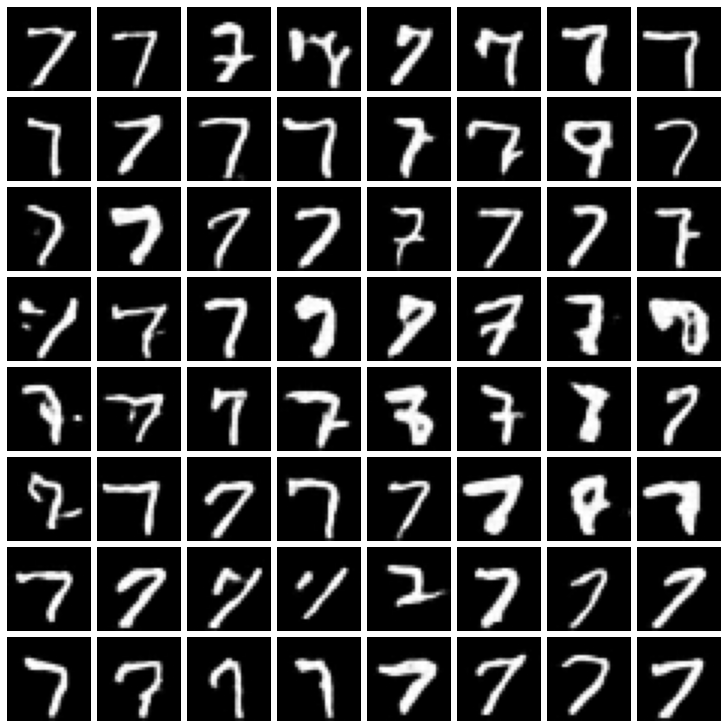

In [68]:
# Perform an embedding lookup and Generate new images
with torch.inference_mode():
    z = model.vq_layer.quantize(priors)
    z = z.permute(0, 3, 1, 2).contiguous()
    pred = model.decoder(z)

generated_samples = np.array(np.clip((pred + 0.5).cpu().numpy(), 0., 1.) * 255, dtype=np.uint8)
generated_samples = generated_samples.reshape(8, 8, 28, 28)

fig = plt.figure(figsize=(10, 10), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_samples[n_row, n_col], cmap="gray")
        f_ax.axis("off")